# Figure 1 CoMIGHT

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os
from collections import defaultdict
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from sktree.datasets import make_trunk_classification
from sktree.stats.utils import (
    METRIC_FUNCTIONS,
    POSITIVE_METRICS,
    POSTERIOR_FUNCTIONS,
    REGRESSOR_METRICS,
    _compute_null_distribution_coleman,
    _non_nan_samples,
)

seed = 12345
rng = np.random.default_rng(seed)

In [3]:
def make_mean_shift(
    # root_dir,
    n_samples=4096,
    n_dim_1=4090,
    mu_viewone=-1,
    mu_viewtwo=1,
    rho=0.2,
    seed=None,
    n_dim_2=6,
    return_params=False,
    overwrite=False,
):
    """Make mean shifted binary classification data.

    X | Y = 0 ~ N(0, I)
    X | Y = 1 ~ N([mu_1, mu_2], [[1, 0.5], [0.5, 1]])

    We want to do a parameter sweep over mu_1 = mu_2 and get:

    - CMI
        - MI of each of the two individually
    - AUC of the combined views
        - AUC of each of the two indivdually
    - S@98 of the combined views
        - S@98 of each of the two individually
    """
    # output_fname = (
    #     root_dir
    #     / "data"
    #     / "mean_shiftv2"
    #     / f"mean_shiftv2_{n_samples}_{n_dim_1}_{n_dim_2}_{seed}.npz"
    # )
    # output_fname.parent.mkdir(exist_ok=True, parents=True)
    # if not overwrite and output_fname.exists():
    #     return

    rng = np.random.default_rng(seed)

    method = "svd"

    mu_1_vec = np.array([mu_viewone, mu_viewtwo])
    mu_0_vec = np.array([0, 0])
    cov = np.array([[1.0, rho], [rho, 1.0]])

    X = np.vstack(
        (
            rng.multivariate_normal(mu_1_vec, cov, n_samples // 2, method=method),
            rng.multivariate_normal(mu_0_vec, np.eye(2), n_samples // 2, method=method),
        )
    )
    assert X.shape[1] == 2
    view_1 = X[:, (0,)]
    view_1 = np.hstack(
        (view_1, rng.normal(loc=0, scale=1, size=(X.shape[0], n_dim_1 - 1)))
    )
    view_2 = X[:, 1:]
    # add noise to the second view so that view_2 = (n_samples, n_dim_2)
    view_2 = np.concatenate(
        (view_2, rng.standard_normal(size=(n_samples, n_dim_2 - view_2.shape[1]))),
        axis=1,
    )

    X = np.concatenate((view_1, view_2), axis=1)
    y = np.concatenate((np.zeros(n_samples // 2), np.ones(n_samples // 2)))
    if return_params:
        return X, y, [mu_0_vec, mu_1_vec], [np.eye(2), cov]
    return X, y

    # np.savez_compressed(output_fname, X=X, y=y)


def make_multi_modal(
    # root_dir,
    n_samples=4096,
    n_dim_1=4090,
    mu_viewone=0,
    mu_viewtwo=0,
    mix=0.75,
    rho=0.8,
    seed=None,
    n_dim_2=6,
    return_params=False,
    overwrite=False,
):
    """Make multi-modal binary classification data."""
    rng = np.random.default_rng(seed)
    default_n_informative = 2

    method = "svd"
    mu_1_vec = np.array([mu_viewone, mu_viewtwo])
    mu_0_vec = np.array([0, 0])
    cov = np.array([[1.0, rho], [rho, 1.0]])

    mixture_idx = rng.choice(2, n_samples // 2, replace=True, shuffle=True, p=[mix, 1 - mix])  # type: ignore
    norm_params = [[mu_0_vec, np.eye(2)], [mu_1_vec, cov]]
    X_mixture = np.fromiter(
        (
            rng.multivariate_normal(*(norm_params[i]), size=1, method=method)
            for i in mixture_idx
        ),
        dtype=np.dtype((float, 2)),
    )

    X = np.vstack(
        (
            rng.multivariate_normal(np.zeros(2), cov, n_samples // 2, method=method),
            X_mixture.reshape(n_samples // 2, 2),
        )
    )

    assert X.shape[1] == 2
    y = np.concatenate((np.zeros(n_samples // 2), np.ones(n_samples // 2)))
    return X, y

In [4]:
n_samples = 1000
n_dim_1 = 10
n_dim_2 = 6
seed = 1234

In [10]:
X, y = make_mean_shift(
    n_samples=n_samples,
    n_dim_1=n_dim_1,
    n_dim_2=n_dim_2,
    seed=seed,
    mu_viewone=-1,
    mu_viewtwo=1,
    rho=0.2,
)

print(X.shape, y.shape)

(1000, 16) (1000,)


In [12]:
results = defaultdict(list)

y_labels = [0, 1]
for label in y_labels:
    y_idx = np.argwhere(y == label).squeeze()

    X_label = X[y_idx, :]

    results["class"].extend([label] * len(y_idx))
    # X_label_view = X_label[:, (view,)].squeeze().tolist()
    # results["view"].extend([view + 1] * len(y_idx))
    results["view_one"].extend(X_label[:, (0,)].squeeze().tolist())
    results["view_two"].extend(X_label[:, (10,)].squeeze().tolist())

    # for view in range(2):
    #     results["label"].extend([label] * len(y_idx))
    #     X_label_view = X_label[:, (view,)].squeeze().tolist()
    #     results["view"].extend([view + 1] * len(y_idx))
    #     results["data"].extend(X_label_view)

# df = pd.DataFrame(columns=["data", "label", "view"])
df = pd.DataFrame(results)
display(df.head())

,class,view_one,view_two
0,0,0.201786,2.282867
1,0,-1.670417,0.522633
2,0,-3.511459,2.173353
3,0,-0.452478,2.743461
4,0,0.073180,2.507986


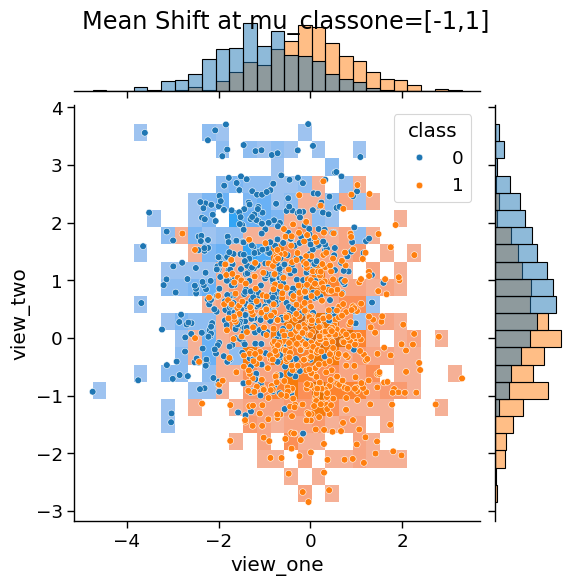

In [17]:
sns.set_context("paper", font_scale=1.5)
# fig, ax = plt.subplots()
g = sns.jointplot(
    x="view_one",
    y="view_two",
    hue="class",
    data=df,
    kind="hist",
)
sns.scatterplot(data=df, x="view_one", y="view_two", hue="class", ax=g.ax_joint)
g = g.fig.suptitle("Mean Shift at mu_classone=[-1,1]")

Text(0.5, 0.98, 'Mean Shift')

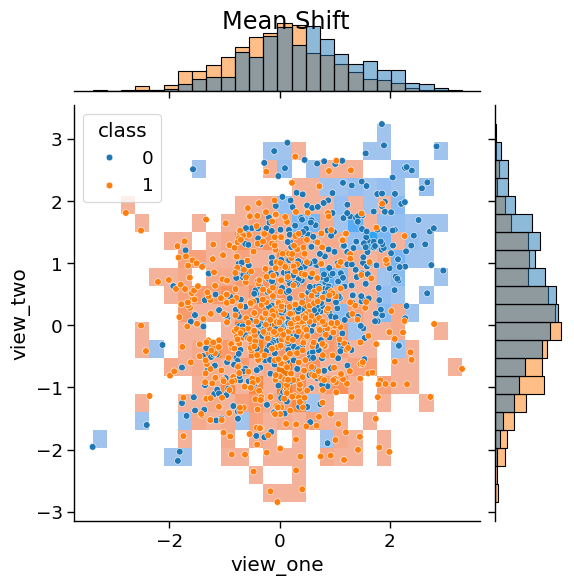

In [101]:
sns.set_context("paper", font_scale=1.5)
# fig, ax = plt.subplots()

g = sns.jointplot(
    x="view_one",
    y="view_two",
    hue="class",
    data=df,
    kind="hist",
)
sns.scatterplot(data=df, x="view_one", y="view_two", hue="class", ax=g.ax_joint)
g.fig.suptitle("Mean Shift")

## Multi-modal

In [11]:
X, y = make_multi_modal(
    n_samples=n_samples * 5,
    mu_viewone=1,
    mu_viewtwo=-1,
    rho=0.8,
    n_dim_1=n_dim_1,
    n_dim_2=n_dim_2,
    seed=seed,
)

print(X.shape, y.shape)

(5000, 2) (5000,)


In [12]:
results = defaultdict(list)

y_labels = [0, 1]
for label in y_labels:
    y_idx = np.argwhere(y == label).squeeze()

    X_label = X[y_idx, :]

    results["class"].extend([label] * len(y_idx))
    # X_label_view = X_label[:, (view,)].squeeze().tolist()
    # results["view"].extend([view + 1] * len(y_idx))
    results["view_one"].extend(X_label[:, (0,)].squeeze().tolist())
    results["view_two"].extend(X_label[:, (1,)].squeeze().tolist())

    # for view in range(2):
    #     results["label"].extend([label] * len(y_idx))
    #     X_label_view = X_label[:, (view,)].squeeze().tolist()
    #     results["view"].extend([view + 1] * len(y_idx))
    #     results["data"].extend(X_label_view)

# df = pd.DataFrame(columns=["data", "label", "view"])
df = pd.DataFrame(results)
display(df.head())

,class,view_one,view_two
0,0,-1.028650,-0.621884
1,0,-0.380122,0.048561
2,0,0.737738,-0.233643
3,0,-0.447365,-0.842094
4,0,0.678273,-0.028605


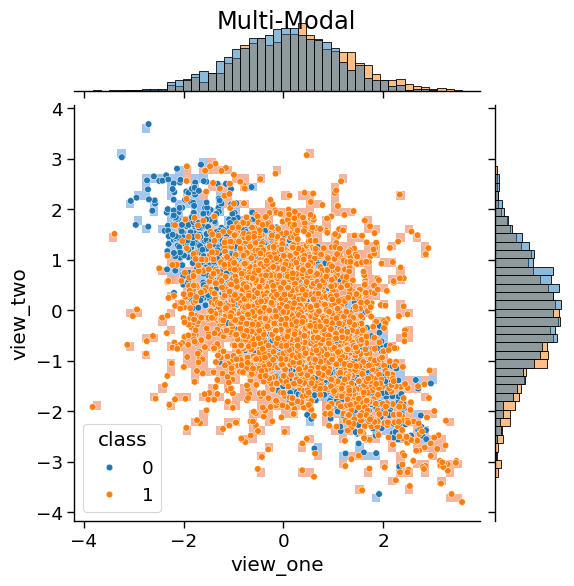

In [10]:
sns.set_context("paper", font_scale=1.5)
# fig, ax = plt.subplots()
g = sns.jointplot(
    x="view_one",
    y="view_two",
    hue="class",
    data=df,
    kind="hist",
)
sns.scatterplot(data=df, x="view_one", y="view_two", hue="class", ax=g.ax_joint)

g = g.fig.suptitle("Multi-Modal")

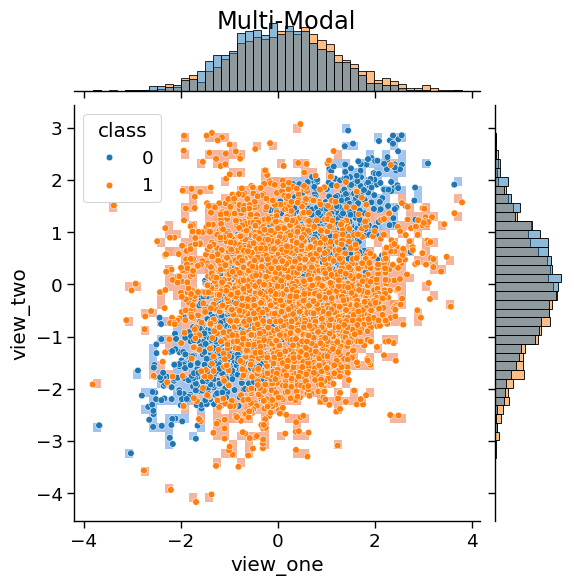

In [13]:
sns.set_context("paper", font_scale=1.5)
# fig, ax = plt.subplots()
g = sns.jointplot(
    x="view_one",
    y="view_two",
    hue="class",
    data=df,
    kind="hist",
)
sns.scatterplot(data=df, x="view_one", y="view_two", hue="class", ax=g.ax_joint)

g = g.fig.suptitle("Multi-Modal")